In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [4]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

def optimize_hyperparameters(X_train, y_train):

    param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 300]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_  # Convert back to MSE
    }

def train_optimized_family_models(df):
    # Dictionary to store optimized models
    optimized_models = {}
    
    # Get unique families with progress bar
    families = list(df['steel_family'].unique())
    
    for family in tqdm(families, desc="Optimizing Models", unit="family"):
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Optimize hyperparameters
        optimization_results = optimize_hyperparameters(X_train, y_train)
        
        # Train final model with best parameters
        best_model = optimization_results['best_estimator']
        best_model.fit(X_train, y_train)
        
        # Evaluate model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        optimized_models[family] = {
            'model': best_model,
            'best_params': optimization_results['best_params'],
            'best_score': optimization_results['best_score'],
            'train_mse': mean_squared_error(y_train, y_pred_train),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'test_mae': mean_absolute_error(y_test, y_pred_test),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test)
        }
    
    return optimized_models

In [5]:
# # Run optimization
# optimized_family_models = train_optimized_family_models(train_scaled_df)

# for family, model_info in optimized_family_models.items():
#     print(f"Family: {family}")
#     print(f"Best Parameters: {model_info['best_params']}")
#     print(f"Best CV Score (MSE): {model_info['best_score']}")
#     print(f"Test MSE: {model_info['test_mse']}")
#     print(f"Test R2: {model_info['test_r2']}")

# Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
# Best CV Score (MSE): 0.03532225241048171
# Test MSE: 0.03415821618500867
# Test R2: 0.7363546546810392
# Family: IF
# Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
# Best CV Score (MSE): 0.0675499376923866
# Test MSE: 0.06731234100770715
# Test R2: 0.6689365357212078
# Family: HSLA
# Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
# Best CV Score (MSE): 0.01933508683578099
# Test MSE: 0.019624365856035563
# Test R2: 0.7800756981077155

In [6]:
optimized_family_models_grid = {'CMn': {'model': XGBRegressor(
               colsample_bytree=1.0, learning_rate=0.1, max_depth=5,
               min_child_weight=5, n_estimators=300, subsample=0.8, random_state=42),
    'best_params': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}},
 'IF': {'model': XGBRegressor(
               colsample_bytree=0.6,learning_rate=0.11, max_depth=5,
               min_child_weight=3, n_estimators=200, subsample=1.0, random_state=42),
  'best_params': {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}},
 'HSLA': {'model': XGBRegressor(
               colsample_bytree=1.0, learning_rate=0.1, max_depth=5,
               min_child_weight=1, n_estimators=200, subsample=0.8, random_state=42),
  'best_params': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}}
}

In [7]:
def train_optimized_models(df, optimized_models_dict):
    trained_models = {}
    for family, model_config in optimized_models_dict.items():
        # Filter data for the specific steel family
        family_data = df[df['steel_family'] == family]
        
        # Separate features and target
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Create the model using the best estimator from grid search
        model = model_config['model']
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred_test = model.predict(X_test)
        
        # Store the model with performance metrics
        trained_models[family] = {
            'model': model,
            'test_r2': r2_score(y_test, y_pred_test),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'test_mae': mean_absolute_error(y_test, y_pred_test)
        }
    
    return trained_models

In [8]:
trained_models = train_optimized_models(train_scaled_df, optimized_family_models_grid)

In [9]:
def plot_predicted_vs_actual(optimized_models, df):
    plt.figure(figsize=(15, 5 * len(optimized_models)))
    
    for i, (family, model_info) in enumerate(optimized_models.items(), 1):
        plt.subplot(len(optimized_models), 1, i)
        
        # Recreate train/test split
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Predict
        y_pred_test = model_info['model'].predict(X_test)
        
        # Plot
        plt.scatter(y_test, y_pred_test, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{family} - Predicted vs Actual R-Value')
        plt.xlabel('Actual R-Value')
        plt.ylabel('Predicted R-Value')
        
        # Annotate with R² and MSE
        plt.text(0.05, 0.95, 
                 f"Test R²: {model_info['test_r2']:.4f}\n" +
                 f"Test MSE: {model_info['test_mse']:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

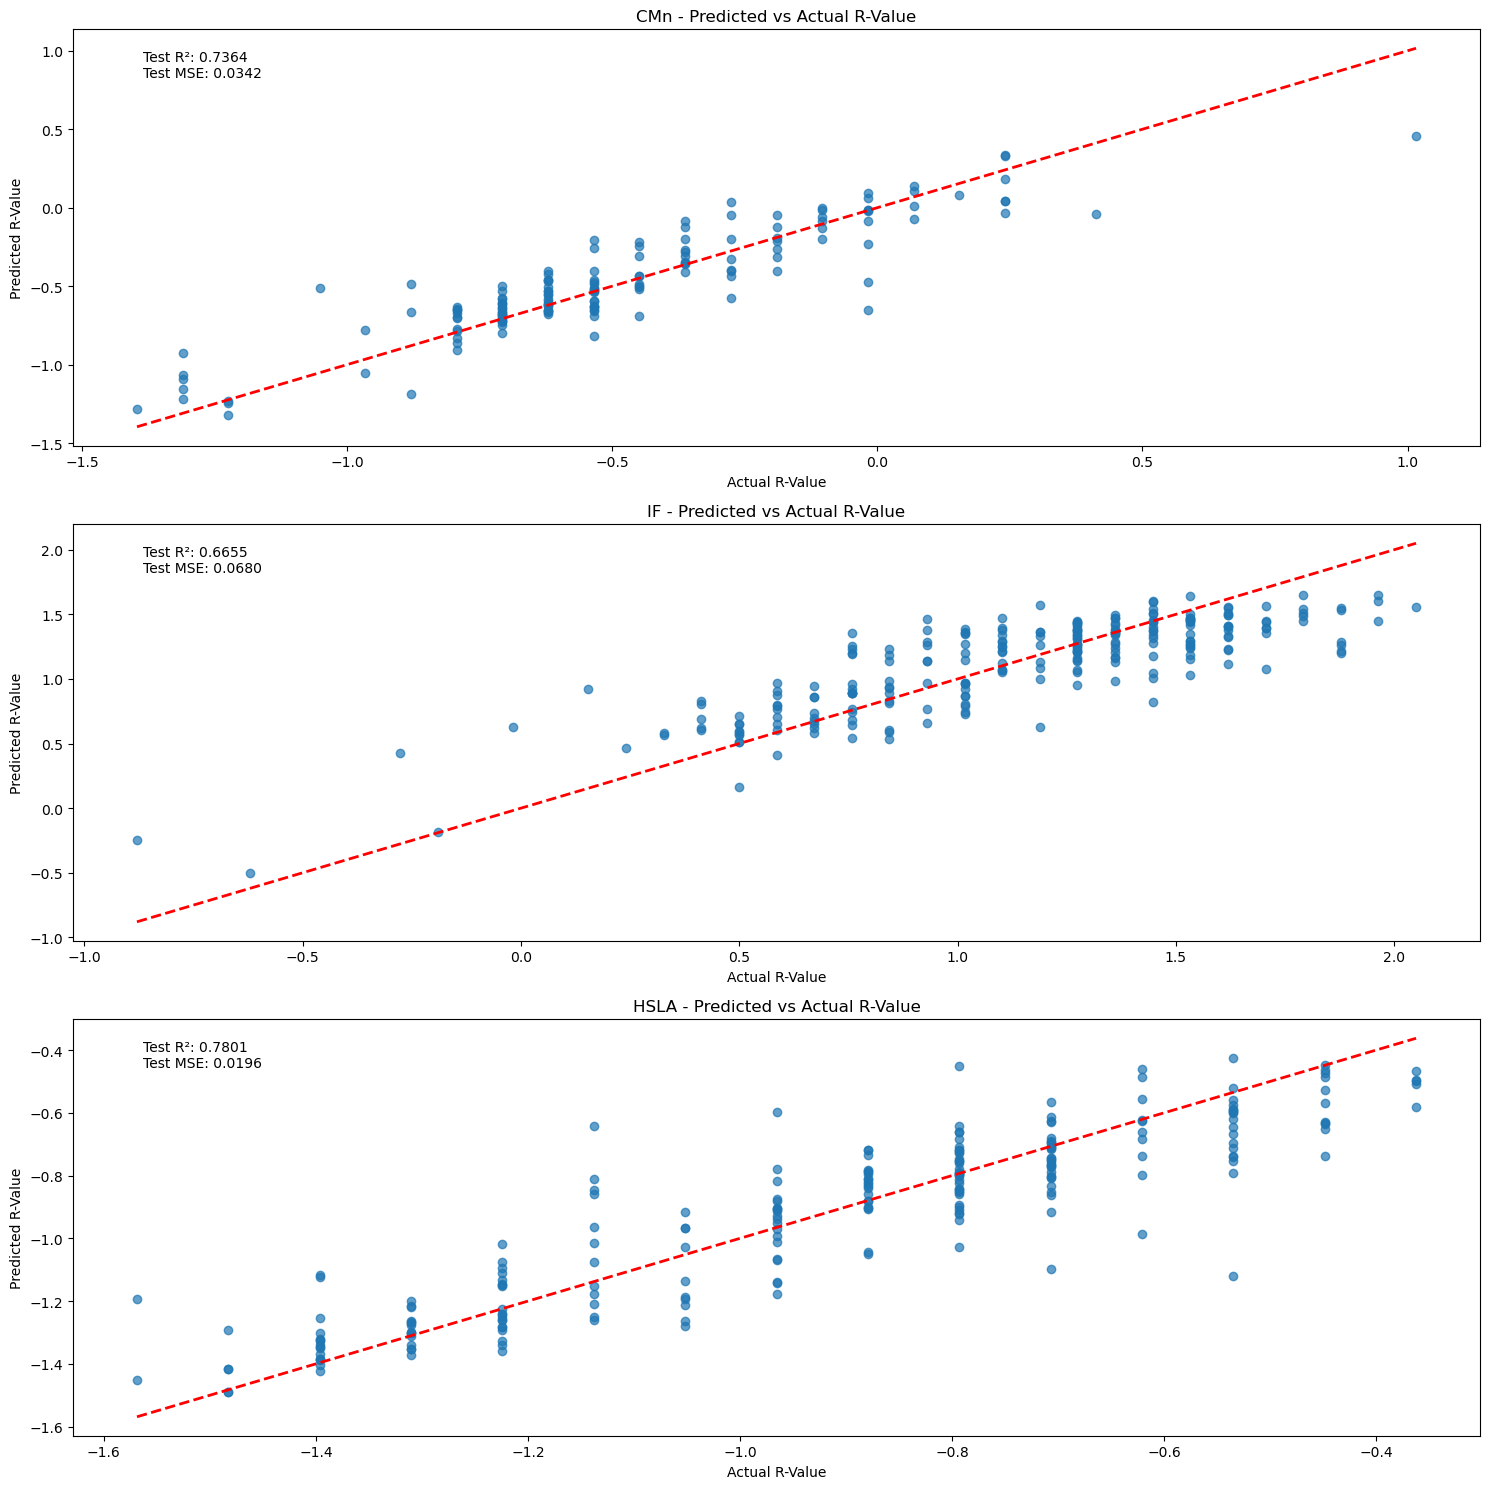

In [10]:
plot_predicted_vs_actual(trained_models, test_scaled_df)

In [11]:
df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=False)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [12]:
# trained_models_no_model_output = train_optimized_family_models(train_scaled_df)

In [13]:
trained_models_no_model_output_dict =  {'CMn': {'model': XGBRegressor(
               colsample_bytree=0.6, learning_rate=0.1, max_depth=7,
               min_child_weight=3, n_estimators=100, subsample=1.0, random_state=42), 'best_params': {'colsample_bytree': 0.6,
   'learning_rate': 0.1,
   'max_depth': 7,
   'min_child_weight': 3,
   'n_estimators': 100,
   'subsample': 1.0}},
 'IF': {'model': XGBRegressor(
               colsample_bytree=0.8,learning_rate=0.1, max_depth=7,
               min_child_weight=5, n_estimators=300, subsample=0.6, random_state=42),
  'best_params': {'colsample_bytree': 0.8,
   'learning_rate': 0.01,
   'max_depth': 7,
   'min_child_weight': 5,
   'n_estimators': 300,
   'subsample': 0.6}},
 'HSLA': {'model': XGBRegressor(
               colsample_bytree=0.6, learning_rate=0.1, max_depth=5,
               min_child_weight=3, n_estimators=200, subsample=1.0, random_state=42),
  'best_params': {'colsample_bytree': 0.6,
   'learning_rate': 0.1,
   'max_depth': 5,
   'min_child_weight': 3,
   'n_estimators': 200,
   'subsample': 1.0}}
}

In [31]:
tmp = train_optimized_models(train_scaled_df, trained_models_no_model_output_dict)

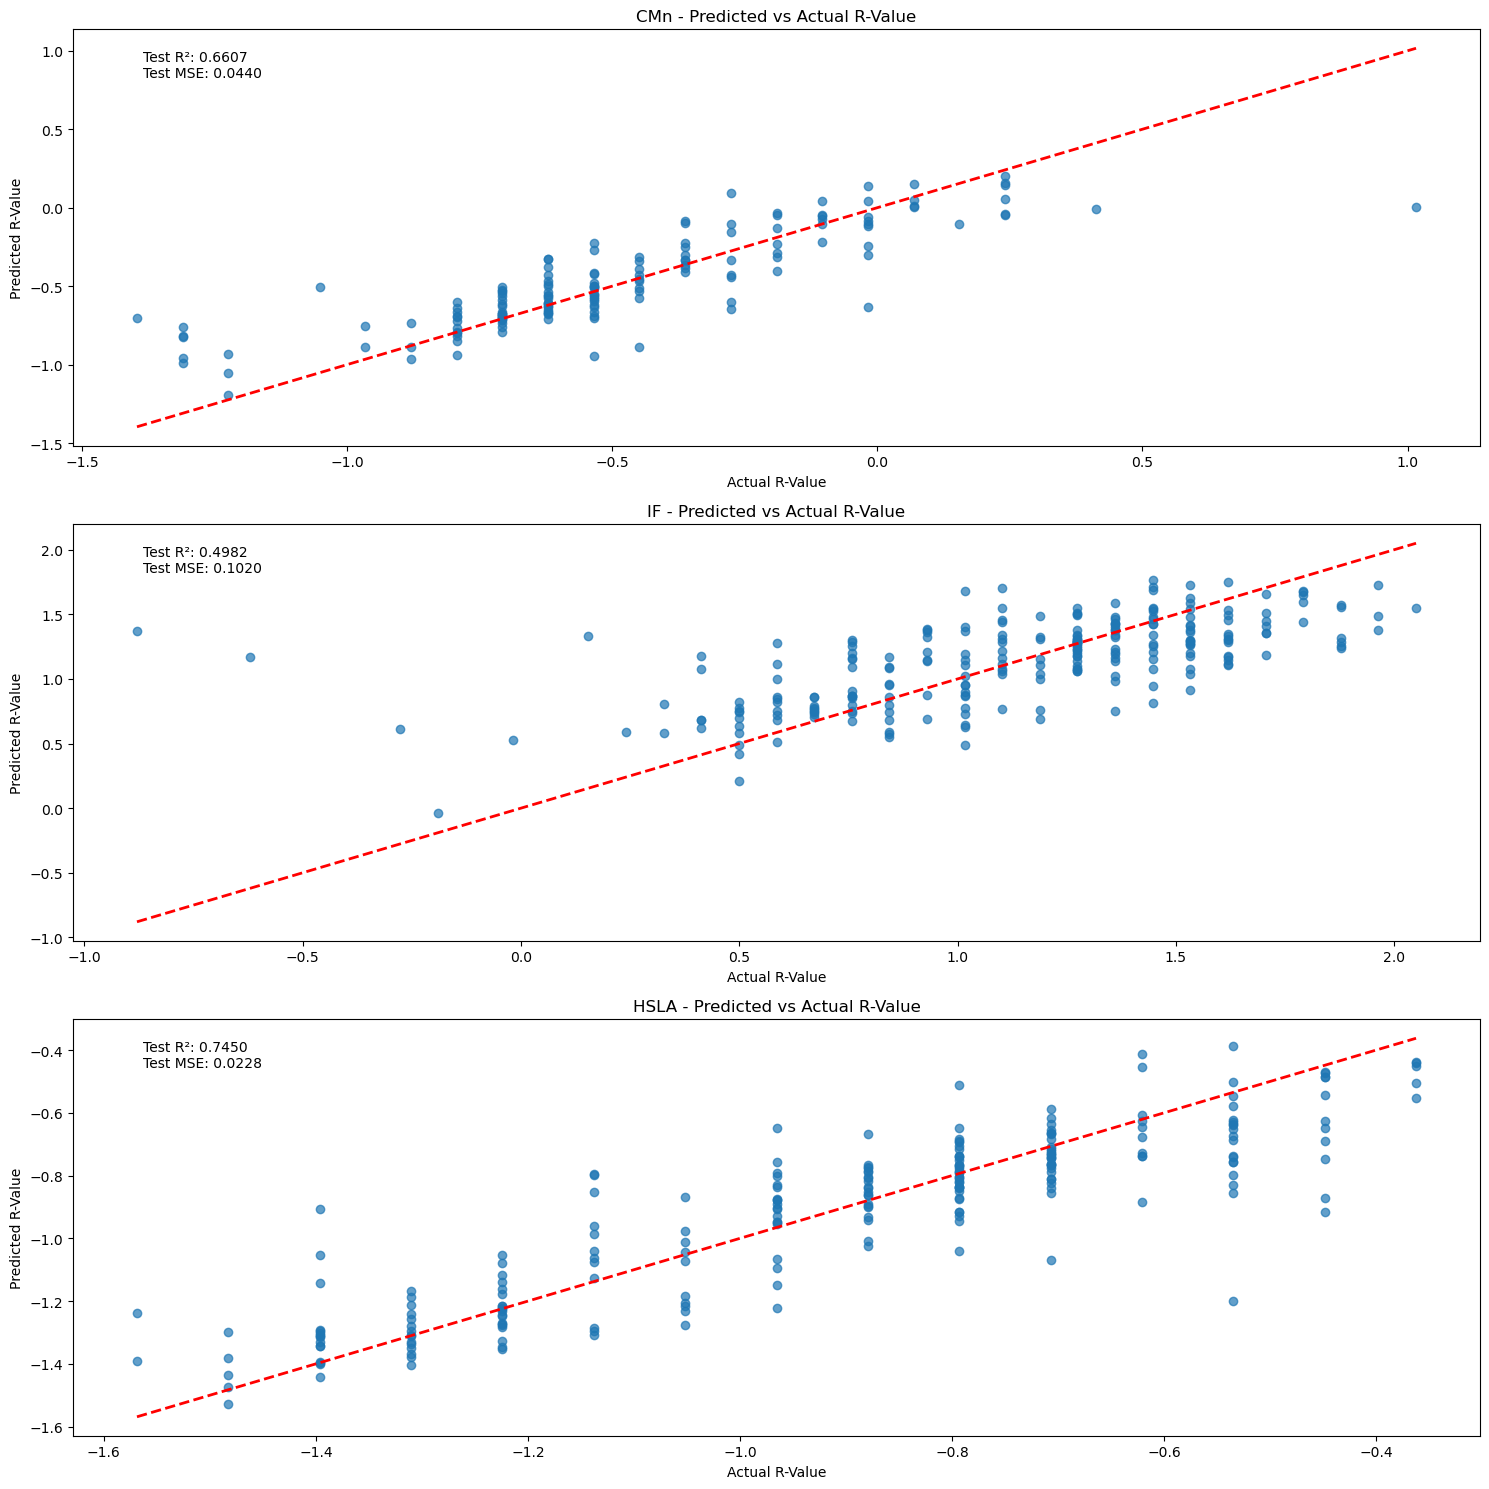

In [32]:
plot_predicted_vs_actual(tmp, test_scaled_df)

In [34]:
all_models = {'RFRegressor': trained_models, 'RF_no_model_output': tmp}
data = []
for model, metrics in all_models.items():
    for category, values in metrics.items():
        data.append({
            'Model': model,
            'Steel family': category,
            'r2_score': values.get('test_r2', None),  # Default to None if key is missing
            'Mean Absolute Error': values.get('test_mae', None),
            'Mean Squared Error': values.get('test_mse', None)
        })

df = pd.DataFrame(data)
df

,Model,Steel family,r2_score,Mean Absolute Error,Mean Squared Error
0,RFRegressor,CMn,0.736355,0.130987,0.034158
1,RFRegressor,IF,0.665523,0.203162,0.068006
2,RFRegressor,HSLA,0.780076,0.097130,0.019624
3,RF_no_model_output,CMn,0.660735,0.143956,0.043956
4,RF_no_model_output,IF,0.498197,0.242805,0.102027
5,RF_no_model_output,HSLA,0.745015,0.106347,0.022753
